In [1]:
%%capture
%pip install tensorboard
%pip install pytorch
%pip install torchvision
%pip install category_encoders

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils import data

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# sklearn classes
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# sklearn utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Encoders
from category_encoders import OrdinalEncoder, OneHotEncoder
%load_ext tensorboard

from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import time
import os
import copy

# Preprocessing and augmenting

In [3]:
chan_num = 3

train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Grayscale(chan_num),
    transforms.Normalize((0.5,), (0.3,))
  ])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(chan_num), transforms.Normalize((0.5,), (0.3,))])
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(chan_num), transforms.Normalize((0.5,), (0.3,)),])

test_dataset = datasets.ImageFolder(root='triple_mnist/test', transform=train_transform)
train_dataset = datasets.ImageFolder(root='triple_mnist/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='triple_mnist/val', transform=val_transform)

In [4]:
batch_size = 128

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [5]:
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

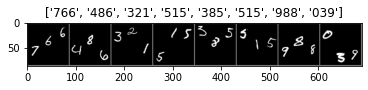

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,])
    std = np.array([0.3,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = image_datasets['test'].classes
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:8])

imshow(out,title=[class_names[x] for x in classes][0:8])

# Model itself

In [7]:
class MultiClassifier(nn.Module):
  def __init__(self):
    super(MultiClassifier, self).__init__()
    self.ConvLayer1 = nn.Sequential(
    nn.Conv2d(3, 84, 3), # 3, 256, 256
    nn.MaxPool2d(2), # op: 16, 127, 127
    nn.ReLU(), # op: 64, 127, 127
    )
    self.ConvLayer2 = nn.Sequential(
    nn.Conv2d(84, 128, 3), # 64, 127, 127
    nn.MaxPool2d(2), #op: 128, 63, 63
    nn.ReLU() # op: 128, 63, 63
    )
    self.ConvLayer3 = nn.Sequential(
    nn.Conv2d(128, 256, 3), # 128, 63, 63
    nn.MaxPool2d(2), #op: 256, 30, 30
    nn.ReLU() #op: 256, 30, 30
    )
    self.ConvLayer4 = nn.Sequential(
    nn.Conv2d(256, 512, 3), # 256, 30, 30
    nn.MaxPool2d(2), #op: 512, 3, 3
    nn.ReLU(), #op: 512, 3, 3
    nn.Dropout(0.2)
    )
    self.Linear1 = nn.Linear(512 * 3 * 3, 1024)
    self.Linear2 = nn.Linear(1024, 256)
    self.Linear3 = nn.Linear(256, 30)
    self.act = nn.Sigmoid()
  def forward(self, x):
    x = self.ConvLayer1(x)
    x = self.ConvLayer2(x)
    x = self.ConvLayer3(x)
    x = self.ConvLayer4(x)
    x = x.view(x.size(0), -1)
    x = self.Linear1(x)
    x = self.Linear2(x)
    x = self.Linear3(x)
    return self.act(x)

In [8]:
def ml_split(num):
  res = [0] * 30
  res[int(num[0])] = 1
  res[int(num[1]) + 10] = 1
  res[int(num[2]) + 20] = 1
  return res

In [9]:
def hot_to_ind(tens):
  _, preds = torch.max(tens[0].view(-1, 10), dim=1)
  for i in range(1, len(tens)):
    _, pred1 = torch.max(tens[i].view(-1, 10), dim=1)
    preds = torch.cat((preds, pred1))
  preds = preds.view(-1, 3)
  return preds

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_total_corrects = 0
            running_any_corrects = 0

            # Iterate over data.
            num_steps = 0
            print(len(dataloaders[phase]))
            for inputs, labels in dataloaders[phase]:
                num_steps += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = hot_to_ind(outputs)
                    target = torch.from_numpy(np.array([ml_split(image_datasets[phase].classes[label]) for label in labels])).to(device)
                    target = target.type(torch.FloatTensor).to(device)
                    loss = criterion(outputs, target)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                ind_target = hot_to_ind(target)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_any_corrects += torch.sum(preds == ind_target)
                for i in range(len(ind_target)):
                  running_total_corrects += torch.equal(preds[i], ind_target[i])
                  
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_total_acc = float(running_total_corrects) / dataset_sizes[phase]
            epoch_any_acc = running_any_corrects.double() / (3 * dataset_sizes[phase])

            print(f'{phase} \nLoss: {epoch_loss:.4f} Any Acc: {epoch_any_acc:.4f} Total Acc: {epoch_total_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_total_acc > best_acc:
                best_acc = epoch_total_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:


from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import time
import os
import copy

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model_ft = MultiClassifier()

model_ft = model_ft.to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.NAdam(model_ft.parameters(), lr=0.001, momentum_decay=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

cuda


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
model_ft.save('cnn97.pt')

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def test_model(model):
  model.eval()
  with torch.no_grad():

    running_loss = 0.0
    running_any_corrects = 0
    running_total_corrects = 0

    for inputs, labels in dataloaders['test']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      preds = hot_to_ind(outputs)
      target = torch.from_numpy(np.array([ml_split(image_datasets['test'].classes[label]) for label in labels])).to(device)
      target = target.type(torch.FloatTensor).to(device)

      loss = F.binary_cross_entropy(outputs, target)

      ind_target = hot_to_ind(target)

      running_loss += loss.item() * inputs.size(0)
      running_any_corrects += torch.sum(preds == ind_target)
      for i in range(len(ind_target)):
        running_total_corrects += torch.equal(preds[i], ind_target[i])

    epoch_loss = running_loss / dataset_sizes['test']
    epoch_total_acc = float(running_total_corrects) / dataset_sizes['test']
    epoch_any_acc = running_any_corrects.double() / (3 * dataset_sizes['test'])

    print(f'Test: \nLoss: {epoch_loss} Any Acc: {epoch_any_acc:.4f} Total Acc: {epoch_total_acc:.4f}')

In [ ]:
test_model(model_ft)

Test: 
Loss: 0.006679819885641336 Any Acc: 0.9922 Total Acc: 0.9766


In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/MLA2/cnn97_02.pt')

In [ ]:
model = torch.load('cnn97_active.pt', map_location=torch.device('cpu'))